# Install & Import

In [15]:
import os
import joblib
import time
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from statistics import geometric_mean
from imblearn.combine import SMOTETomek
from sklearn.model_selection import StratifiedKFold, cross_val_score
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real, Integer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import (
    make_scorer,
    precision_score,
    roc_auc_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    balanced_accuracy_score,
    auc,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    average_precision_score,
    matthews_corrcoef,
    balanced_accuracy_score,
)

from imblearn.over_sampling import ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import EditedNearestNeighbours, ClusterCentroids

import xgboost as xgb
from xgboost import plot_importance

from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real, Integer
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.mixed import (
    MixedVariableMating,
    MixedVariableSampling,
    MixedVariableDuplicateElimination,
)
from pymoo.core.problem import StarmapParallelization
from pymoo.optimize import minimize

class DefaultSampler:
    def fit_resample(self, X, y):
        return X, y

# Settings/Constant variables

In [16]:
# Constant Variables
CPU_CORES_COUNT = 14
RND_STATE = 37

TRAIN_TEST_SPLIT = 0.30
BALANCER_SCORER = 'pr_auc'
HYPERPARAM_TUNING_SCORER = 'pr_auc'
BEST_SAMPLER = 'default'

HYPERPARAM_TUNING_POPSIZE = 16
HYPERPARAM_TUNING_NFOLDS = 5
# TERMINATION = ("n_gen", 10)
TERMINATION = ("time", "06:00:00")

# For min-max scaled data use: minmax_modeling.csv
DATASET_FILENAME = "cls_default_modeling.csv"
# BALANCE_METHOD = ''

In [17]:
# Set the maximum number of CPU cores to be used by joblib
os.environ["LOKY_MAX_CPU_COUNT"] = str(CPU_CORES_COUNT)

# Samplers and scorers

In [18]:
SCORERS = {
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True),
    'pr_auc': make_scorer(average_precision_score, needs_proba=True),
    'mcc': make_scorer(matthews_corrcoef),
    'balanced_accuracy': make_scorer(balanced_accuracy_score)
}

BALANCE_METHODS = {
    "default": DefaultSampler(),  # No sampling, trivial computation.
    "smote_enn": SMOTEENN(random_state=RND_STATE, n_jobs=CPU_CORES_COUNT),  # Uses SMOTE followed by ENN cleaning, most computationally intensive.
    "smote_tomek": SMOTETomek(random_state=RND_STATE, n_jobs=CPU_CORES_COUNT),  # Combines SMOTE with Tomek link removal (two-phase process).
    "enn": EditedNearestNeighbours(n_jobs=CPU_CORES_COUNT),  # Cleans samples via nearest neighbors, processing whole dataset.
    "smote_borderline": BorderlineSMOTE(random_state=RND_STATE),  # Identifies borderline examples before interpolation.
    "smote": SMOTE(random_state=RND_STATE),  # Basic SMOTE using k-NN interpolation.
    "adasyn": ADASYN(random_state=RND_STATE),  # Similar to SMOTE but with extra weighting computations.
    "cc": ClusterCentroids(random_state=RND_STATE),  # Clustering with few centroids is relatively fast.
}

C:\Users\philipz\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


# Read data

In [19]:
modeling = pd.read_csv(f"data/{DATASET_FILENAME}")
modeling.drop(columns=['weight','target'], inplace=True)

Observations with worthy class: 1148 (0.27%)


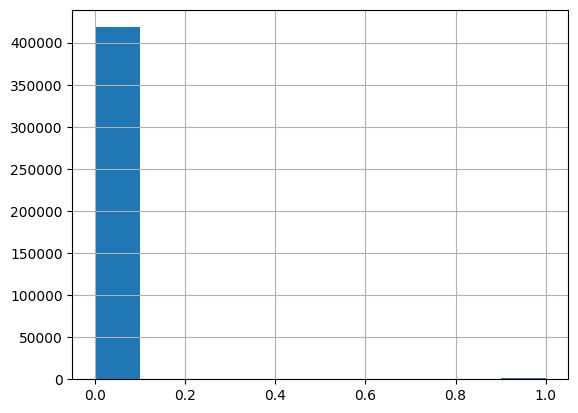

In [20]:
worth = modeling[modeling["worthy"] == 1]
not_worth = modeling[modeling["worthy"] == 0]

modeling["worthy"].hist()
print(
    f"Observations with worthy class: {len(worth)} ({len(worth)/modeling.shape[0]*100:.2f}%)"
)

In [21]:
X = modeling.drop(columns=["worthy"])
y = modeling["worthy"]

# Train/test split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TRAIN_TEST_SPLIT, stratify=y, random_state=RND_STATE
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((293556, 381), (125810, 381), (293556,), (125810,))

In [23]:
X_test.describe()

,BTCUSDT_ADOSC_15m,BTCUSDT_ADOSC_1h,BTCUSDT_ADOSC_1m,BTCUSDT_ADOSC_4h,BTCUSDT_ADOSC_5m,BTCUSDT_ATR_15m,BTCUSDT_ATR_1m,BTCUSDT_ATR_5m,BTCUSDT_OBV_15m,BTCUSDT_OBV_1m,...,txns_h24_sells,txns_h6_buys,txns_h6_sells,txns_m5_buys,txns_m5_sells,volume_h1,volume_h24,volume_h6,volume_m5,weekday
count,125810.000000,125810.000000,125810.000000,125810.000000,125810.000000,125810.000000,125810.000000,125810.000000,125810.000000,125810.000000,...,125810.000000,125810.000000,125810.000000,125810.000000,125810.000000,1.258100e+05,1.258100e+05,1.258100e+05,1.258100e+05,125810.000000
mean,75.622522,-119.171762,1.753278,2705.385393,38.015639,352.401984,78.127269,195.227586,-2595.401640,-1364.601922,...,44.604435,74.368150,44.604435,74.068103,44.467046,3.058322e+04,3.058322e+04,3.058322e+04,3.029857e+04,2.892187
std,2216.692484,7457.570756,204.335805,23253.905028,848.191531,195.849715,59.088348,124.643642,146929.361692,14193.378012,...,126.138864,162.416764,126.138864,161.745356,125.740607,1.552227e+05,1.552227e+05,1.552227e+05,1.546903e+05,1.987109
min,-19860.439504,-39417.404312,-5435.595671,-100627.224236,-15056.711257,40.393249,3.316538,17.764061,-343187.795000,-61229.662000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,-549.111481,-2809.509971,-46.205449,-11119.858325,-181.346632,214.752823,38.825438,108.267672,-100790.871000,-7386.972000,...,0.000000,3.000000,0.000000,3.000000,0.000000,4.497250e+01,4.497250e+01,4.497250e+01,4.455250e+01,1.000000
50%,68.234426,-173.228380,0.572499,1935.224855,24.882108,305.074368,63.213780,164.135177,-19835.094000,-1130.735500,...,1.000000,12.000000,1.000000,12.000000,1.000000,1.167105e+03,1.167105e+03,1.167105e+03,1.159330e+03,3.000000
75%,719.375255,2613.240141,48.703490,14949.067726,246.216673,448.651452,101.572745,251.194200,69569.555250,4804.714000,...,23.000000,68.000000,23.000000,67.000000,23.000000,1.601881e+04,1.601881e+04,1.601881e+04,1.584288e+04,5.000000
max,19129.259336,38627.951982,5554.312244,86378.832281,10380.112162,1815.851978,867.436622,1524.885614,537472.211000,80742.303000,...,4193.000000,5976.000000,4193.000000,5976.000000,4193.000000,2.728435e+07,2.728435e+07,2.728435e+07,2.728435e+07,6.000000


# Fit default model

In [24]:
default_xgb_model = XGBClassifier(
    device="cuda",
    # eval_metric='logloss',
    tree_method='hist',
    random_state=RND_STATE,
    verbosity=2
)
default_xgb_model.fit(X_train, y_train)

default_model_filename = f"models/default_cls_model.joblib"
joblib.dump(default_xgb_model, default_model_filename)

['models/default_cls_model.joblib']

In [25]:
# Predict on the test set
y_pred = default_xgb_model.predict(X_test)
y_pred_proba = default_xgb_model.predict_proba(X_test)[:, 1]

In [26]:
# Calculate evaluation metrics
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)

# Create a dictionary with the evaluation metrics and an additional 'Type' column
results = {
    'Type': ['default'],
    'F1 Score': [f1],
    'MCC': [mcc],
    'PR AUC': [pr_auc],
    'Balanced Accuracy': [balanced_acc],
    'Precision': [precision],
    'Recall': [recall],
    'AUC': [roc_auc],
}

# Convert the dictionary into a DataFrame
DF_SCORES = pd.DataFrame(results)

# Display the DataFrame with the evaluation metrics and the Type column
print(DF_SCORES)

      Type  F1 Score       MCC    PR AUC  Balanced Accuracy  Precision  \
0  default   0.00565  0.016607  0.032017           0.501418        0.1   

     Recall       AUC  
0  0.002907  0.909942  



Confusion Matrix:
[[125457      9]
 [   343      1]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    125466
           1       0.10      0.00      0.01       344

    accuracy                           1.00    125810
   macro avg       0.55      0.50      0.50    125810
weighted avg       0.99      1.00      1.00    125810



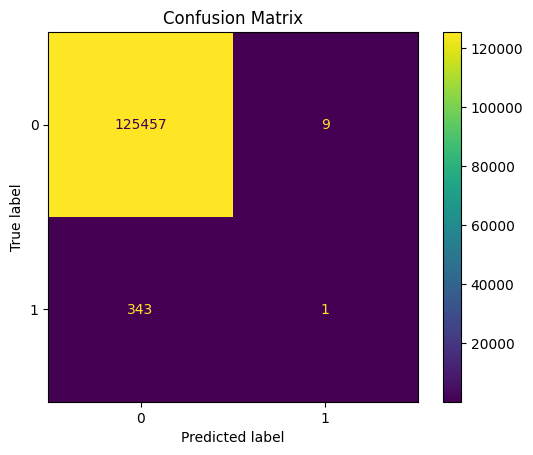

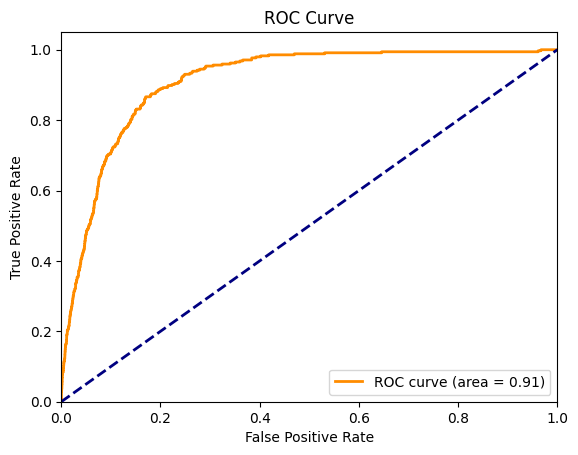

In [27]:
# Display confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc_curve = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc_curve:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

<Figure size 1000x800 with 0 Axes>

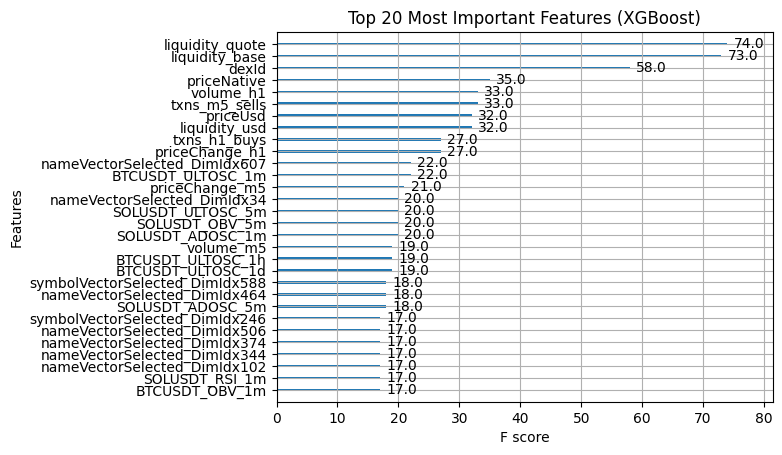

In [28]:
plt.figure(figsize=(10, 8))
plot_importance(
    default_xgb_model, max_num_features=30, importance_type="weight", show_values=True
)
plt.title("Top 20 Most Important Features (XGBoost)")
plt.show()

# Hiperparameter optimization

## Define problem class

In [29]:
class XGBoostOptimizationProblem(ElementwiseProblem):
    def __init__(self, x_data, y_data, scorer, cv_folds=5, rnd_state=None, **kwargs):
        self.x_data = x_data
        self.y_data = y_data
        self.cv_folds = cv_folds
        self.scorer = scorer
        self.rnd_state = rnd_state
        self.eval_times = []

        self.skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=rnd_state)
        
        hyperparameters = {
            "learning_rate": Real(bounds=(0.001, 0.3)),
            "max_depth": Integer(bounds=(2, 12)),
            "min_child_weight": Integer(bounds=(1, 20)),
            "subsample": Real(bounds=(0.5, 1.0)),
            "colsample_bytree": Real(bounds=(0.1, 1.0)),
            "colsample_bylevel": Real(bounds=(0.2, 1.0)),
            "colsample_bynode": Real(bounds=(0.2, 1.0)),
            "gamma": Real(bounds=(0, 10)),
            "reg_alpha": Real(bounds=(0, 50)),
            "reg_lambda": Real(bounds=(0, 50)),
            "scale_pos_weight": Real(bounds=(1, 300)),
            "max_delta_step": Integer(bounds=(0, 10)),
            "n_estimators": Integer(bounds=(100, 2000))
        }
        
        super().__init__(vars=hyperparameters, n_obj=1, **kwargs)

    def _evaluate(self, X, out, *args, **kwargs):
        start_time = time.time()
        
        model = XGBClassifier(
            device="cuda",
            eval_metric='logloss',
            tree_method='hist',
            learning_rate=X["learning_rate"],
            max_depth=X["max_depth"],
            min_child_weight=X["min_child_weight"],
            subsample=X["subsample"],
            colsample_bytree=X["colsample_bytree"],
            colsample_bylevel=X["colsample_bylevel"],
            colsample_bynode=X["colsample_bynode"],
            gamma=X["gamma"],
            reg_alpha=X["reg_alpha"],
            reg_lambda=X["reg_lambda"],
            scale_pos_weight=X["scale_pos_weight"],
            max_delta_step=X["max_delta_step"],
            n_estimators=X["n_estimators"],
            random_state=self.rnd_state
        )
        
        cv_scores = cross_val_score(
            model,
            self.x_data,
            self.y_data,
            cv=self.skf,
            scoring=self.scorer,
            n_jobs=1
        )
        
        # mean_score = np.mean(cv_scores)
        # mean_score = geometric_mean(cv_scores)
        mean_score = 0 if (np.array(cv_scores) <= 0).any() else len(np.array(cv_scores)) / np.sum(1 / np.array(cv_scores))
        
        eval_time = time.time() - start_time
        self.eval_times.append(eval_time)
        print(f'Params {X}')
        print(f'Mean CV score: {mean_score}  Evaluation time: {eval_time:.2f}s (mean {np.mean(self.eval_times):.2f}s)')
        print()
        out["F"] = -mean_score

## Run search

In [30]:
# pool = Pool(cpu_count())
# runner = StarmapParallelization(pool.starmap)

problem = XGBoostOptimizationProblem(
    X_train,
    y_train,
    cv_folds=HYPERPARAM_TUNING_NFOLDS,
    scorer=SCORERS[HYPERPARAM_TUNING_SCORER],
    rnd_state=RND_STATE
)
algorithm = GA(
    pop_size=HYPERPARAM_TUNING_POPSIZE,
    sampling=MixedVariableSampling(),
    mating=MixedVariableMating(
        eliminate_duplicates=MixedVariableDuplicateElimination()
    ),
    eliminate_duplicates=MixedVariableDuplicateElimination(),
)

res = minimize(
    problem,
    algorithm,
    termination=TERMINATION,
    verbose=True,
)

Params {'learning_rate': 0.10467329771262454, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.6140344027812279, 'colsample_bytree': 0.597101429894096, 'colsample_bylevel': 0.37980251243355145, 'colsample_bynode': 0.9179441187089732, 'gamma': 3.9126185057841556, 'reg_alpha': 35.860316537938346, 'reg_lambda': 8.906629380463471, 'scale_pos_weight': 89.64596514573947, 'max_delta_step': 10, 'n_estimators': 549}
Mean CV score: 0.03994406261798181  Evaluation time: 75.11s (mean 75.11s)

Params {'learning_rate': 0.2648799109754206, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.6028209514075267, 'colsample_bytree': 0.676380956789483, 'colsample_bylevel': 0.9220714909550567, 'colsample_bynode': 0.9768003328405661, 'gamma': 8.859923815867086, 'reg_alpha': 48.81815406741385, 'reg_lambda': 49.02948136611639, 'scale_pos_weight': 189.99825075487465, 'max_delta_step': 10, 'n_estimators': 1690}
Mean CV score: 0.03402774219695891  Evaluation time: 94.88s (mean 84.99s)

Params {'learning_r

In [31]:
if len(res.F) == 1:
    if isinstance(res.X, dict):
        print(f"Best gene: reward= {-res.f} variables= {res.X.items()}")
    else:
        print(f"Best gene: reward= {-res.f} variables= {res.X}")
else:
    print("Pareto front:")
    for front, var in zip(res.F, res.X):
        print(f"front=", front, "variables=", list(var.values()))

Best gene: reward= 0.056615179390179966 variables= dict_items([('learning_rate', 0.035736604032645634), ('subsample', 0.7299954408803551), ('colsample_bytree', 0.8427858682729327), ('colsample_bylevel', 0.2959464790327913), ('colsample_bynode', 0.8729951319835212), ('gamma', 3.433402976250739), ('reg_alpha', 41.57621819219386), ('reg_lambda', 14.539566311637397), ('scale_pos_weight', 4.645136119278926), ('max_depth', 12), ('min_child_weight', 5), ('max_delta_step', 9), ('n_estimators', 495)])


## Fit tuned model

In [32]:
tuned_xgb_model = XGBClassifier(device="cuda",
                                    eval_metric='logloss',
                                    tree_method='hist',
                                    random_state=RND_STATE,
                                    **res.X
                                   )

# tuned_xgb_model = XGBClassifier(device="cuda",
#                                     eval_metric='logloss',
#                                     tree_method='hist',
#                                     learning_rate=0.12112208608133633,
#                                     max_depth=10,
#                                     min_child_weight=3,
#                                     subsample=0.8267385974461718,
#                                     colsample_bytree=0.9506632815909901,
#                                     colsample_bylevel=0.855127271779765,
#                                     colsample_bynode=0.8341463897734002,
#                                     gamma=0.1470838427758604,
#                                     reg_alpha=0.9016353480752304,
#                                     reg_lambda=1.9227886249861494,
#                                     scale_pos_weight=0.1185523622795644,
#                                     max_delta_step=2,
#                                     n_estimators=512,
#                                     random_state=RND_STATE
#                                    )

tuned_xgb_model.fit(X_train, y_train)
joblib.dump(tuned_xgb_model, "models/tuned_cls_model.joblib")

['models/tuned_cls_model.joblib']

SCORES:
F1 Score:          0.0319
MCC:               0.0564
PR AUC:            0.0523
Balanced Accuracy: 0.5086
Precision:         0.1875
Recall:            0.0174
AUC:               0.9245

Confusion Matrix:
[[125440     26]
 [   338      6]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    125466
           1       0.19      0.02      0.03       344

    accuracy                           1.00    125810
   macro avg       0.59      0.51      0.52    125810
weighted avg       1.00      1.00      1.00    125810



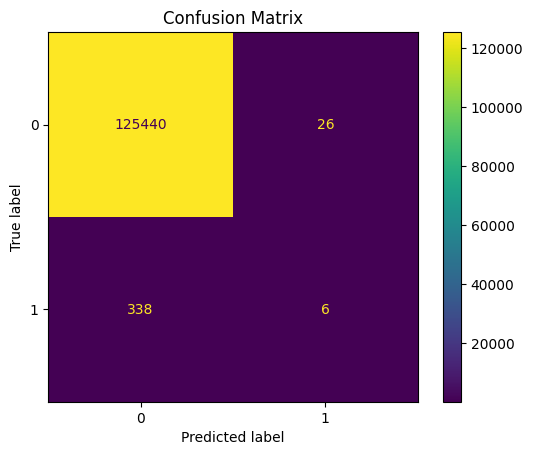

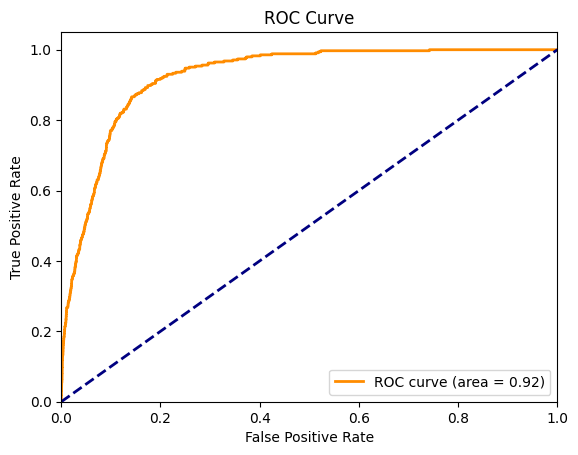

In [33]:
# Predict on the test set
y_pred = tuned_xgb_model.predict(X_test)
y_pred_proba = tuned_xgb_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)

# Print the metrics
print("SCORES:")
print(f"F1 Score:          {f1:.4f}")
print(f"MCC:               {mcc:.4f}")
print(f"PR AUC:            {pr_auc:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Precision:         {precision:.4f}")
print(f"Recall:            {recall:.4f}")
print(f"AUC:               {roc_auc:.4f}")

# Display confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc_curve = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc_curve:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

<Figure size 1000x800 with 0 Axes>

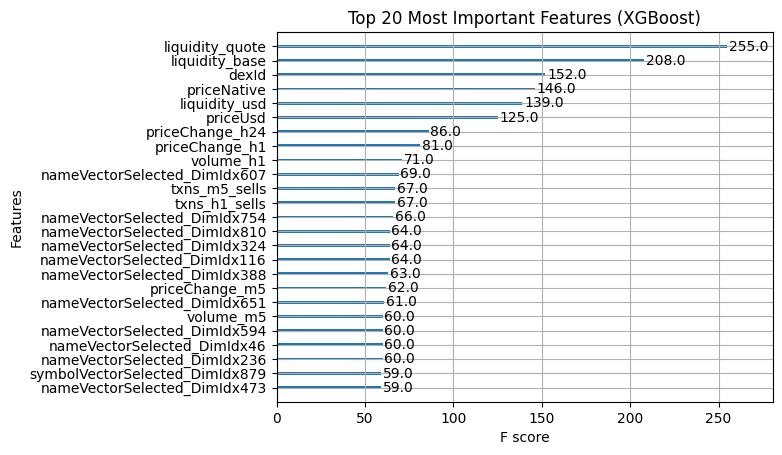

In [34]:
plt.figure(figsize=(10, 8))
plot_importance(
    tuned_xgb_model, max_num_features=25, importance_type="weight", show_values=True
)
plt.title("Top 20 Most Important Features (XGBoost)")
plt.show()

# Dataset balancer optimization

## Run search

In [35]:
best_metric = -1
best_method = None
best_pipeline = None
results = []

for method_name, sampler in BALANCE_METHODS.items():
    pipeline = ImbPipeline([
        ('sampler', sampler),
        ('model', xgb.XGBClassifier(
            device="cuda",
            seed=RND_STATE,
            eval_metric='logloss',
            tree_method='hist',
            verbosity=2,
            **res.X
        ))
    ])
    
    cv = StratifiedKFold(n_splits=5,
                         shuffle=True,
                         random_state=RND_STATE)
    
    cv_results = cross_validate(
        estimator=pipeline,
        X=X_train,
        y=y_train,
        cv=cv,
        scoring=SCORERS,
        return_train_score=False,
        n_jobs=1
    )
    
    mean_scores = {
        'f1': np.mean(cv_results['test_f1']),
        'precision': np.mean(cv_results['test_precision']),
        'recall': np.mean(cv_results['test_recall']),
        'roc_auc': np.mean(cv_results['test_roc_auc']),
        'pr_auc': np.mean(cv_results['test_pr_auc']),
        'mcc': np.mean(cv_results['test_mcc']),
        'balanced_accuracy': np.mean(cv_results['test_balanced_accuracy'])
    }
    
    results.append({
        "Method": method_name,
        **mean_scores
    })
    
    print(f"Metoda: {method_name}")
    print(f"CV F1: {mean_scores['f1']:.4f}, PR AUC: {mean_scores['pr_auc']:.4f}, MCC: {mean_scores['mcc']:.4f}\n")
    
    if mean_scores[BALANCER_SCORER] > best_metric:
        best_metric = mean_scores[BALANCER_SCORER]
        best_method = method_name
        best_pipeline = pipeline

Metoda: default
CV F1: 0.0351, PR AUC: 0.0585, MCC: 0.0751

Metoda: smote_enn
CV F1: 0.1037, PR AUC: 0.0497, MCC: 0.1164

Metoda: smote_tomek
CV F1: 0.1036, PR AUC: 0.0464, MCC: 0.1094

Metoda: enn
CV F1: 0.0390, PR AUC: 0.0577, MCC: 0.0725

Metoda: smote_borderline
CV F1: 0.0962, PR AUC: 0.0465, MCC: 0.0939

Metoda: smote
CV F1: 0.1065, PR AUC: 0.0451, MCC: 0.1126

Metoda: adasyn
CV F1: 0.1009, PR AUC: 0.0450, MCC: 0.1061

Metoda: cc
CV F1: 0.0055, PR AUC: 0.0136, MCC: -0.0004



## Examine results

In [36]:
# Podsumowanie wyników
balancer_results = pd.DataFrame(results).sort_values(by=BALANCER_SCORER, ascending=False)
print("\nPodsumowanie wyników walidacji krzyżowej:")
print(balancer_results)


Podsumowanie wyników walidacji krzyżowej:
             Method        f1  precision    recall   roc_auc    pr_auc  \
0           default  0.035079   0.310967  0.018634  0.922175  0.058543   
3               enn  0.038992   0.254545  0.021134  0.923158  0.057660   
1         smote_enn  0.103686   0.068756  0.211436  0.915910  0.049662   
4  smote_borderline  0.096231   0.094760  0.098269  0.901730  0.046485   
2       smote_tomek  0.103552   0.074024  0.172911  0.912486  0.046401   
5             smote  0.106501   0.076143  0.177880  0.910826  0.045122   
6            adasyn  0.100882   0.072411  0.166693  0.912358  0.045019   
7                cc  0.005465   0.002740  0.976374  0.823759  0.013589   

        mcc  balanced_accuracy  
0  0.075145           0.509262  
3  0.072548           0.510483  
1  0.116355           0.601781  
4  0.093859           0.547855  
2  0.109381           0.583491  
5  0.112614           0.585963  
6  0.106137           0.580410  
7 -0.000353           0.50

In [37]:
BEST_SAMPLER = balancer_results['Method'].iloc[0]

In [38]:
best_pipeline.fit(X_train, y_train)

# balnced_model_filename = f"models/balanced_cls_model.joblib"
# joblib.dump(best_pipeline, balnced_model_filename)

Pipeline(steps=[('sampler',
                 <__main__.DefaultSampler object at 0x000002993F3D8B90>),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=0.2959464790327913,
                               colsample_bynode=0.8729951319835212,
                               colsample_bytree=0.8427858682729327,
                               device='cuda', early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               featur...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.035736604032645634, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=9, max_depth=12, max_leaves=None,
                               min_child_weight=5, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=495, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [39]:
y_pred = best_pipeline.predict(X_test)
y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]

In [40]:
test_metrics = {
    "f1": f1_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, zero_division=0),
    "recall": recall_score(y_test, y_pred, zero_division=0),
    "roc_auc": roc_auc_score(y_test, y_pred_proba),
    "pr_auc": average_precision_score(y_test, y_pred_proba),
    "mcc": matthews_corrcoef(y_test, y_pred),
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred)
}

print("\nWyniki na zbiorze testowym:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")


Wyniki na zbiorze testowym:
f1: 0.0319
precision: 0.1875
recall: 0.0174
roc_auc: 0.9245
pr_auc: 0.0523
mcc: 0.0564
balanced_accuracy: 0.5086


In [41]:
# Calculate evaluation metrics
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)

results = {
    'Type': BEST_SAMPLER,
    'F1 Score': f1,
    'MCC': mcc,
    'PR AUC': pr_auc,
    'Balanced Accuracy': balanced_acc,
    'Precision': precision,
    'Recall': recall,
    'AUC': roc_auc,
}

# Dodajemy nowy wiersz do DataFrame
DF_SCORES.loc[len(DF_SCORES)] = results

# Wyświetlamy DataFrame z dodanym wierszem
print(DF_SCORES)

      Type  F1 Score       MCC    PR AUC  Balanced Accuracy  Precision  \
0  default  0.005650  0.016607  0.032017           0.501418     0.1000   
1  default  0.031915  0.056437  0.052349           0.508617     0.1875   

     Recall       AUC  
0  0.002907  0.909942  
1  0.017442  0.924455  



Confusion Matrix:
[[125440     26]
 [   338      6]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    125466
           1       0.19      0.02      0.03       344

    accuracy                           1.00    125810
   macro avg       0.59      0.51      0.52    125810
weighted avg       1.00      1.00      1.00    125810



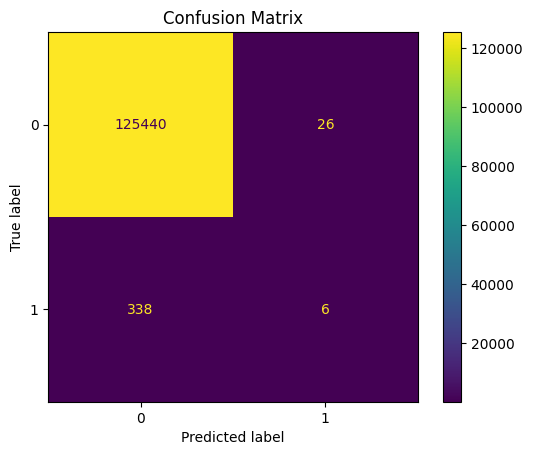

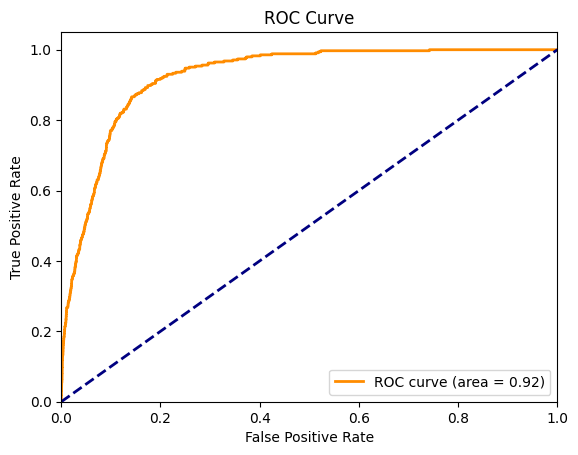

In [42]:
# Display confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc_curve = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc_curve:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

<Figure size 1000x800 with 0 Axes>

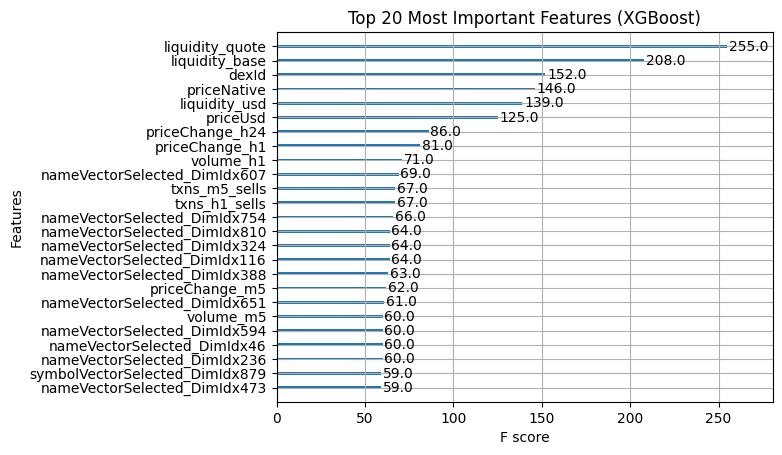

In [43]:
plt.figure(figsize=(10, 8))
plot_importance(
    best_pipeline.named_steps['model'], max_num_features=25, importance_type="weight", show_values=True
)
plt.title("Top 20 Most Important Features (XGBoost)")
plt.show()

# Final model

In [59]:
X_final_train, X_final_test, y_final_train, y_final_test = train_test_split(
    X, y, test_size=0.01, stratify=y, random_state=RND_STATE
)

In [60]:
X_res_final_train, y_res_final_train = BALANCE_METHODS[BEST_SAMPLER].fit_resample(X_final_train, y_final_train)

In [61]:
final_xgb_model = XGBClassifier(
            device="cuda",
            seed=RND_STATE,
            eval_metric='logloss',
            tree_method='hist',
            verbosity=2,
            **res.X
        )
final_xgb_model.fit(X_res_final_train, y_res_final_train)
joblib.dump(final_xgb_model, "models/final_cls_model.joblib")

['models/final_cls_model.joblib']

SCORES:
F1 Score:          0.0000
MCC:               0.0000
PR AUC:            0.1381
Balanced Accuracy: 0.5000
Precision:         0.0000
Recall:            0.0000
AUC:               0.9349

Confusion Matrix:
[[4183    0]
 [  11    0]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4183
           1       0.00      0.00      0.00        11

    accuracy                           1.00      4194
   macro avg       0.50      0.50      0.50      4194
weighted avg       0.99      1.00      1.00      4194



C:\Users\philipz\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\philipz\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\philipz\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

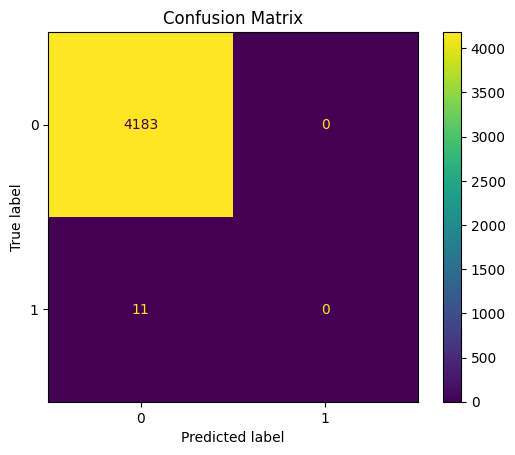

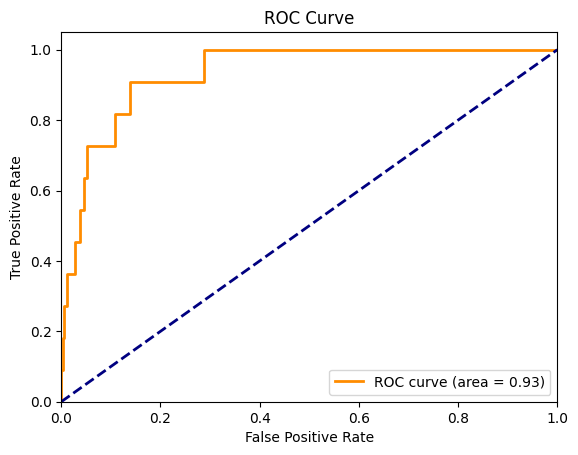

In [62]:
# Predict on the test set
y_pred = final_xgb_model.predict(X_final_test)
y_pred_proba = final_xgb_model.predict_proba(X_final_test)[:, 1]

# Calculate evaluation metrics
f1 = f1_score(y_final_test, y_pred)
precision = precision_score(y_final_test, y_pred, zero_division=0)
recall = recall_score(y_final_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_final_test, y_pred_proba)
pr_auc = average_precision_score(y_final_test, y_pred_proba)
mcc = matthews_corrcoef(y_final_test, y_pred)
balanced_acc = balanced_accuracy_score(y_final_test, y_pred)

# Print the metrics
print("SCORES:")
print(f"F1 Score:          {f1:.4f}")
print(f"MCC:               {mcc:.4f}")
print(f"PR AUC:            {pr_auc:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Precision:         {precision:.4f}")
print(f"Recall:            {recall:.4f}")
print(f"AUC:               {roc_auc:.4f}")

# Display confusion matrix and classification report
cm = confusion_matrix(y_final_test, y_pred)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_final_test, y_pred))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_final_test, y_pred_proba)
roc_auc_curve = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc_curve:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

<Figure size 1000x800 with 0 Axes>

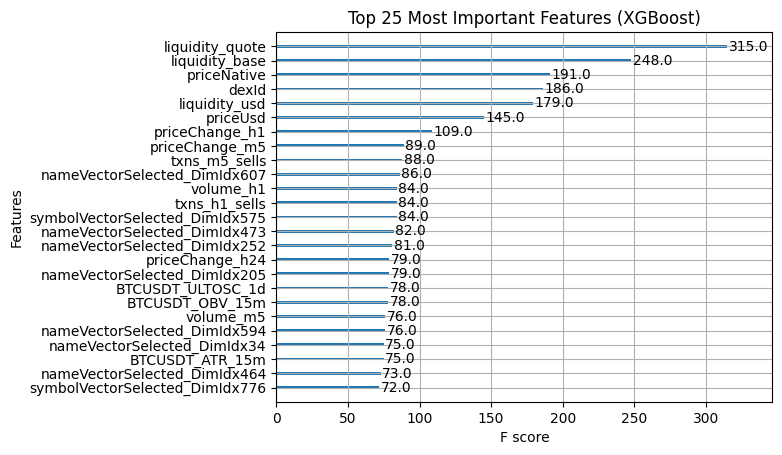

In [63]:
plt.figure(figsize=(10, 8))
plot_importance(
    final_xgb_model, max_num_features=25, importance_type="weight", show_values=True
)
plt.title("Top 25 Most Important Features (XGBoost)")
plt.show()